**<h1>IMPORT LIBRARIES</h1>**

In [1]:
import os
import re
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

**<h1>READ DATASET</h1>**

In [ ]:
data = pd.read_csv('./resetted_index_cleaned_polarity_roberta.csv', index_col=0)
data

In [ ]:
pos = data[data['sentiment'] == 'positive'].head(312564)
neu = data[data['sentiment'] == 'neutral'].head(312564)
neg = data[data['sentiment'] == 'negative'].head(312564)
df = pd.concat([pos, neu, neg], ignore_index=True)

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1, 'neutral': 2})
df.head()

**<h1>SPLIT DATASET</h1>**

In [ ]:
X = df['cleaned_review'].tolist()
for index, value in enumerate(X):
    if isinstance(value, float):
        X[index] = str(value)

In [ ]:
y = to_categorical(df['sentiment'])
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**<h1>TOKENIZATION</h1>**

In [2]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
shape = 96
batch_size = 64

In [ ]:
train_encodings = tokenizer(X_train, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

In [ ]:
test_encodings = tokenizer(X_test, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

## **SAVE TOKENIZATION**

In [4]:
save_path_train = './fix/train_encodings/'
save_path_test = './fix/test_encodings/'
save_path_y_train = './fix/y_train/y_train.tfrecord'
save_path_y_test = './fix/y_test/y_test.tfrecord'

In [ ]:
for key, value in train_encodings.items():
    tf.io.write_file(f"{save_path_train}/{key}.tfrecord", tf.io.serialize_tensor(value))

In [ ]:
for key, value in test_encodings.items():
    tf.io.write_file(f"{save_path_test}/{key}.tfrecord", tf.io.serialize_tensor(value))

In [ ]:
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
serialized_tensor_train = tf.io.serialize_tensor(y_train_tensor)
serialized_tensor_test = tf.io.serialize_tensor(y_test_tensor)

In [ ]:
os.makedirs(os.path.dirname(save_path_y_train), exist_ok=True)
os.makedirs(os.path.dirname(save_path_y_test), exist_ok=True)

In [ ]:
tf.io.write_file(save_path_y_train, serialized_tensor_train)
tf.io.write_file(save_path_y_test, serialized_tensor_test)

## **LOAD TOKENIZATION**

In [5]:
serialized_tensor_train = tf.io.read_file(save_path_y_train)
serialized_tensor_test = tf.io.read_file(save_path_y_test)

In [6]:
loaded_tensor_train = tf.io.parse_tensor(serialized_tensor_train, out_type=tf.float32)
loaded_tensor_test = tf.io.parse_tensor(serialized_tensor_test, out_type=tf.float32)

In [7]:
loaded_y_train = loaded_tensor_train.numpy()
loaded_y_test = loaded_tensor_test.numpy()

In [8]:
loaded_train_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_train}/{key}.tfrecord")
    loaded_train_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

In [9]:
loaded_test_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_test}/{key}.tfrecord")
    loaded_test_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

**<h1>CONVERT TO TENSORFLOW DATASET</h1>**

In [10]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'token_type_ids': encodings['token_type_ids']
        },
        tf.constant(labels)
    )).batch(batch_size, drop_remainder=True)

In [ ]:
train_tf_dataset = create_tf_dataset(train_encodings, y_train)
test_tf_dataset = create_tf_dataset(test_encodings, y_test)

In [11]:
train_tf_dataset = create_tf_dataset(loaded_train_encodings, loaded_y_train)
test_tf_dataset = create_tf_dataset(loaded_test_encodings, loaded_y_test)

**<h1>CNN MODEL</h1>**

In [ ]:
#bert_model.bert.pooler.trainable = False
#bert_model.classifier.trainable = False

In [12]:
input_ids = Input(shape=(shape,), dtype=tf.int32, name='input_ids')
token_type_ids = Input(shape=(shape,), dtype=tf.int32, name='token_type_ids')
attention_mask = Input(shape=(shape,), dtype=tf.int32, name='attention_mask')

In [13]:
bert_outputs = bert_model([input_ids, token_type_ids, attention_mask], output_hidden_states=True)
hidden_states = bert_outputs.hidden_states[-1]
logits = bert_outputs.logits

In [14]:
conv1d_layer = Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.025))(hidden_states) #just recently added regularization
maxpooling1d_layer = MaxPooling1D(2)(conv1d_layer)
dropout_layer_1 = Dropout(0.45)(maxpooling1d_layer)

conv1d_layer_2 = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.025))(dropout_layer_1) #just recently added regularization
maxpooling1d_layer_2 = MaxPooling1D(2)(conv1d_layer_2)
dropout_layer_2 = Dropout(0.45)(maxpooling1d_layer_2)

conv1d_layer_3 = Conv1D(256, 3, activation='relu', kernel_regularizer=regularizers.l2(0.025))(dropout_layer_2) #just recently added regularization
globalmaxpooling1d_layer = GlobalMaxPooling1D()(conv1d_layer_3)

combined_features = tf.concat([logits, globalmaxpooling1d_layer], axis=-1)

dense_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.025))(combined_features)
output_layer = Dense(3, activation='softmax')(dense_layer)

**<h1>TRAIN MODEL</h1>**

In [15]:
combined_model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=output_layer)
combined_model.compile(optimizer=Adam(learning_rate=3e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('./fix/bert_cnn_best_model_batch_testing.keras', save_best_only=True, monitor='val_loss', mode='min')

In [17]:
history = combined_model.fit(train_tf_dataset, epochs=50, validation_data=(test_tf_dataset), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
10256/10256 [==============================] - 6962s 678ms/step - loss: 10.3727 - accuracy: 0.7488 - val_loss: 7.9237 - val_accuracy: 0.7910 - lr: 3.0000e-06
Epoch 2/50
10256/10256 [==============================] - 6875s 670ms/step - loss: 5.6836 - accuracy: 0.8333 - val_loss: 4.0274 - val_accuracy: 0.8235 - lr: 3.0000e-06
Epoch 3/50
10256/10256 [==============================] - 6875s 670ms/step - loss: 2.7796 - accuracy: 0.8569 - val_loss: 1.9538 - val_accuracy: 0.8499 - lr: 3.0000e-06
Epoch 4/50
10256/10256 [==============================] - 6875s 670ms/step - loss: 1.3643 - accuracy: 0.8745 - val_loss: 1.0182 - val_accuracy: 0.8584 - lr: 3.0000e-06
Epoch 5/50
10256/10256 [==============================] - 6873s 670ms/step - loss: 0.7403 - accuracy: 0.8885 - val_loss: 0.6350 - val_accuracy: 0.8637 - lr: 3.0000e-06
Epoch 6/50
10256/10256 [==============================] - 6866s 669ms/step - loss: 0.4661 - accuracy: 0.9007 - val_loss: 0.4751 - val_accuracy: 0.8705 - lr: 3.

**<h1>HISTORY LOG</h1>**

In [18]:
with open('./fix/training_history_bert_cnn_best_model_batch_testing.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [19]:
with open('./fix/training_history_bert_cnn_best_model_batch_testing.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)

print(loaded_history)

{'loss': [10.372664451599121, 5.683585166931152, 2.779581069946289, 1.3642979860305786, 0.7402555346488953, 0.4660894572734833, 0.3375885784626007, 0.26620548963546753, 0.21958506107330322, 0.18724600970745087, 0.1619308441877365, 0.13551753759384155], 'accuracy': [0.7488162517547607, 0.833324670791626, 0.8569358587265015, 0.8745307922363281, 0.8884646892547607, 0.9007014036178589, 0.9117787480354309, 0.9218582510948181, 0.9311058521270752, 0.93900066614151, 0.94637131690979, 0.955814003944397], 'val_loss': [7.92369270324707, 4.027375221252441, 1.9537653923034668, 1.0182350873947144, 0.6349844932556152, 0.4751453697681427, 0.416605144739151, 0.3989916443824768, 0.38253501057624817, 0.3847268521785736, 0.4134638011455536, 0.4240821897983551], 'val_accuracy': [0.7909769415855408, 0.8234854936599731, 0.8499040007591248, 0.8584328889846802, 0.8637016415596008, 0.8704991340637207, 0.871811032295227, 0.8714554905891418, 0.8746089339256287, 0.8765074014663696, 0.8725113868713379, 0.8786831498

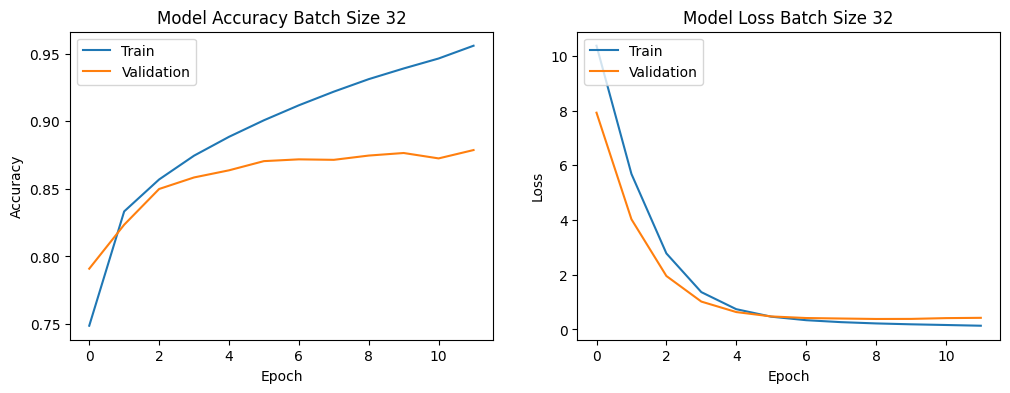

In [20]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy Batch Size 32')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss Batch Size 32')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

In [ ]:
def plot_training_loaded_history(loaded_history):
    accuracy = loaded_history['accuracy']
    val_accuracy = loaded_history['val_accuracy']
    loss = loaded_history['loss']
    val_loss = loaded_history['val_loss']
    
    epochs = range(len(accuracy))
    
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy)
    plt.plot(epochs, val_accuracy)
    plt.title('Model Accuracy Batch Size 16')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(len(epochs)))  # Force x-axis to have integer ticks
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Model Loss Batch Size 16')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(len(epochs)))  # Force x-axis to have integer ticks
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_loaded_history(loaded_history)

**<h1>SAVE MODEL</h1>**

In [ ]:
#combined_model.save('./fix/cnn_classifier_model.keras')

In [ ]:
#combined_model.save_weights('./fix/bert_cnn_model_tfbertmodel_weights')

**<h1>LOAD MODEL</h1>**

In [12]:
custom_objects = {'TFBertForSequenceClassification': TFBertForSequenceClassification}
loaded_model = load_model('./fix/bert_cnn_best_model.keras', custom_objects=custom_objects)

In [ ]:
#custom_objects = {'TFBertForSequenceClassification': TFBertForSequenceClassification}
#loaded_model = load_model('./fix/bert_cnn_model_64_batch.keras', custom_objects=custom_objects, compile=False)
#optimizer = Adam(1e-6)
#loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#loaded_model.load_weights('./fix/bert_cnn_model_64_batch_weights')

In [ ]:
loaded_model.summary()

**<h1>MINI TESTING</h1>**

In [5]:
sentiment_mapping = {
    0: 'Positive',
    1: 'Negative',
    2: 'Neutral'
}

In [6]:
def predict_sentiments(texts):
    encoded_inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')
    input_ids = encoded_inputs['input_ids']
    token_type_ids = encoded_inputs['token_type_ids']
    attention_mask = encoded_inputs['attention_mask']
    
    predictions = loaded_model.predict([input_ids, token_type_ids, attention_mask])
    
    predicted_classes = np.argmax(predictions, axis=1)
    mapped_predictions = [sentiment_mapping[class_index] for class_index in predicted_classes]
    
    return mapped_predictions

In [ ]:
new_texts = ["I hate this.", "This is great!", "It's just fine."]
predictions = predict_sentiments(new_texts)
print("Predicted sentiments:", predictions)

**<h1>VALIDATION</h1>**

In [13]:
y_pred_prob = loaded_model.predict(test_tf_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

4395/4395 [==============================] - 839s 189ms/step


In [14]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

In [15]:
conf_matrix = confusion_matrix(y_true, y_pred)

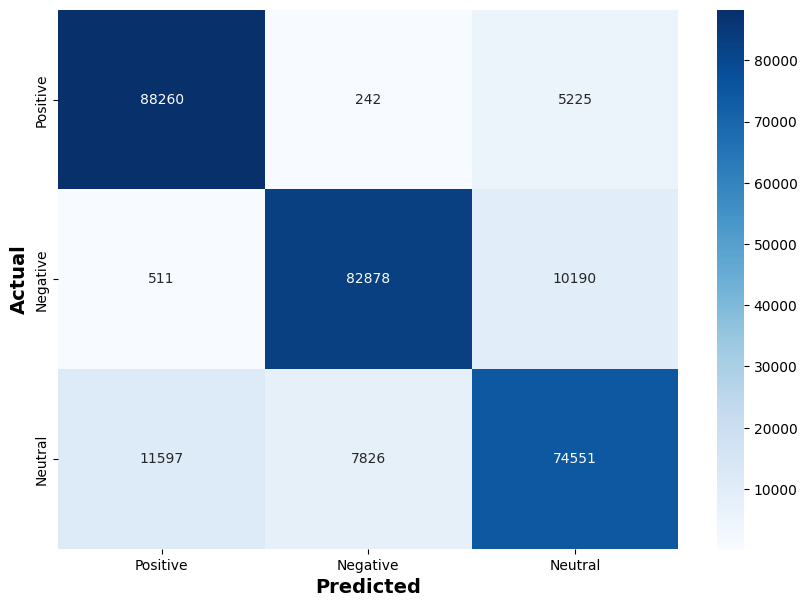

In [16]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.show()

In [17]:
print(classification_report(y_true, y_pred, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.88      0.94      0.91     93727
    Negative       0.91      0.89      0.90     93579
     Neutral       0.83      0.79      0.81     93974

    accuracy                           0.87    281280
   macro avg       0.87      0.87      0.87    281280
weighted avg       0.87      0.87      0.87    281280

